<a href="https://colab.research.google.com/github/jee365/ESAA/blob/main/0516_%EB%B0%9C%ED%91%9C_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **fast.ai 패키지**
- pytorch 기반
- 목표: 딥러닝 모델을 만드는 코드를 스킬 없이 빠르게 학습시켜 사용할 수 있도록 하는 것
- 복잡한 구현 없이 딥러닝 모델을 생성할 수 있음
- 모델 아키텍처의 선택, 전처리, 확대, 테스트, 교육 및 유효성 검사 등 중요한 데이터 선택을 캡슐화한 클래스


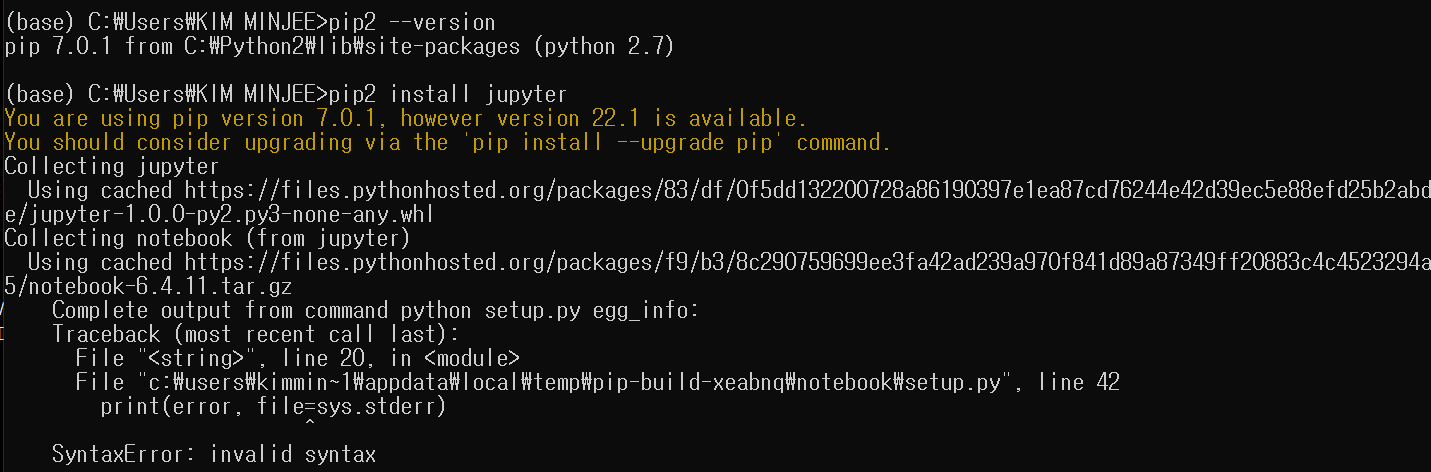

fast.ai 0.7 버전을 사용하기 위해 python 2.7을 설치해봤지만, python 2.7을 지원하는 anaconda 파일 배포가 중지되어 더 이상 jupyter notebook이 실행되지 않음

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


코랩의 경우도 버전 문제가 해결되지 않음

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 7.5 MB/s 
     |████████████████████████████████| 1.2 MB 51.5 MB/s 
     |████████████████████████████████| 342 kB 52.5 MB/s 
     |████████████████████████████████| 4.2 MB 41.2 MB/s 
     |████████████████████████████████| 197 kB 61.3 MB/s 
     |████████████████████████████████| 59 kB 8.1 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 136 kB 58.7 MB/s 
     |████████████████████████████████| 212 kB 47.8 MB/s 
     |████████████████████████████████| 1.1 MB 50.4 MB/s 
     |████████████████████████████████| 127 kB 72.7 MB/s 
     |████████████████████████████████| 144 kB 66.6 MB/s 
     |████████████████████████████████| 271 kB 58.4 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 46.8 MB/s 
     |████████████████████████████████| 596 kB 59.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the p

In [ ]:
from fastbook import *

fast.ai의 기능을 실행하기 위해 다양한 함수들을 불러왔지만 자세한 설명은 생략

In [ ]:
from torch.utils.data import Dataset
import os

class CollabFilterDataset(Dataset):
    def __init__(self, path, user_col, item_col, ratings):
        self.ratings,self.path = ratings.values.astype(np.float32),path
        self.n = len(ratings)
        (self.users,self.user2idx,self.user_col,self.n_users) = self.proc_col(user_col)
        (self.items,self.item2idx,self.item_col,self.n_items) = self.proc_col(item_col)
        self.min_score,self.max_score = min(ratings),max(ratings)
        self.cols = [self.user_col,self.item_col,self.ratings]

    @classmethod
    def from_data_frame(cls, path, df, user_name, item_name, rating_name):
        return cls(path, df[user_name], df[item_name], df[rating_name])

    @classmethod
    def from_csv(cls, path, csv, user_name, item_name, rating_name):
        df = pd.read_csv(os.path.join(path,csv))
        return cls.from_data_frame(path, df, user_name, item_name, rating_name)

    def proc_col(self,col):
        uniq = col.unique()
        name2idx = {o:i for i,o in enumerate(uniq)}
        return (uniq, name2idx, np.array([name2idx[x] for x in col]), len(uniq))

    def __len__(self): return self.n
    def __getitem__(self, idx): return [o[idx] for o in self.cols]

    def get_data(self, val_idxs, bs):
        val, trn = zip(*split_by_idx(val_idxs, *self.cols))
        return ColumnarModelData(self.path, PassthruDataset(*trn), PassthruDataset(*val), bs)

    def get_model(self, n_factors):
        model = EmbeddingDotBias(n_factors, self.n_users, self.n_items, self.min_score, self.max_score)
        return CollabFilterModel((model))

    def get_learner(self, n_factors, val_idxs, bs, **kwargs):
        return CollabFilterLearner(self.get_data(val_idxs, bs), self.get_model(n_factors), **kwargs)

In [ ]:
class BasicModel():
    def __init__(self,model,name='unnamed'): self.model,self.name = model,name 
    def get_layer_groups(self, do_fc=False): return children(self.model)

In [ ]:
import torch.nn as nn


def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.05,0.05)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        res = um.sum(1) + self.ub(users).squeeze() + self.ib(items).squeeze()
        return F.sigmoid(res) * (self.max_score-self.min_score) + self.min_score

class CollabFilterLearner(Learner):
    def __init__(self, data, models, opt_fn, **kwargs):
        super().__init__(data, models,opt_fn, **kwargs)
        self.crit = F.mse_loss

class CollabFilterModel(BasicModel):
    def get_layer_groups(self): return self.model

In [ ]:
class ModelData():
    """Encapsulates DataLoaders and Datasets for training, validation, test. Base class for fastai *Data classes."""
    def __init__(self, path, trn_dl, val_dl, test_dl=None):
        self.path,self.trn_dl,self.val_dl,self.test_dl = path,trn_dl,val_dl,test_dl

    @classmethod
    def from_dls(cls, path,trn_dl,val_dl,test_dl=None):
        #trn_dl,val_dl = DataLoader(trn_dl),DataLoader(val_dl)
        #if test_dl: test_dl = DataLoader(test_dl)
        return cls(path, trn_dl, val_dl, test_dl)

    @property
    def is_reg(self): return self.trn_ds.is_reg
    @property
    def is_multi(self): return self.trn_ds.is_multi
    @property
    def trn_ds(self): return self.trn_dl.dataset
    @property
    def val_ds(self): return self.val_dl.dataset
    @property
    def test_ds(self): return self.test_dl.dataset
    @property
    def trn_y(self): return self.trn_ds.y
    @property
    def val_y(self): return self.val_ds.y


In [ ]:
class PassthruDataset(Dataset):
    def __init__(self,*args):
        *xs,y=args
        self.xs,self.y = xs,y

    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return [o[idx] for o in self.xs] + [self.y[idx]]

    @classmethod
    def from_data_frame(self, df, cols_x, col_y):
        cols = [df[o] for o in cols_x+[col_y]]
        return self(*cols)

In [ ]:
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y[:,None]

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y)

In [ ]:
class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)



In [ ]:
from torch import nn
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [ ]:
import numpy as np
from torch import nn
import torch.optim as optim

**get_cv_idxs**(n, cv_idx=0, val_pct=0.2, seed=42): validation set의 인덱스를 가져오는 역할

- n: 전체 데이터 수
- cv_idx: 시작 인덱스
- val_pct: validation set 비율

In [ ]:
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):

    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [ ]:
def split_by_idx(idxs, *a):
    mask = np.zeros(len(a[0]),dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask],o[~mask]) for o in a]

####**1. Shalllow Learning**

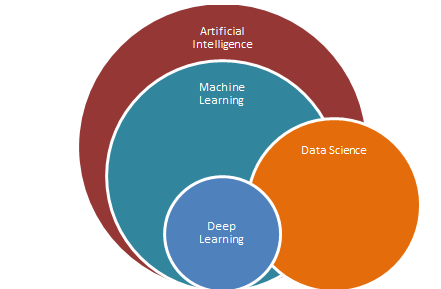

머신러닝은 컴퓨터 시스템이 스스로 데이터로부터 학습할 수 있게 하는 인공지능의 한 분야 -> **딥러닝** 포함

- 선형 회귀
- 로지스틱 회귀
- 나이브 베이즈 분류
- SVM(Support Vector Machine)
- 의사결정 나무
- 인공신경망(딥러닝)

이 중 인공신경망을 제외한 선형 회귀, 로지스틱 회귀 등의 알고리즘은 모두 **Shallow Learning**에 포함

- **wd**: 가중치 감소로 함수의 복잡도를 조정
- **n_factors**: embedding matrix의 차수
- **CollabFilterDataset**: 데이터 로드 모듈
- **get_learner**: 모델을 초기화하는 역할(첫번째 모델)
- optimizer는 Adam으로 설정
- learn.fit으로 모델 fitting(learning rate: 1e-2, epochs: 2) -> nueral net에 **2개의 embedding layer를 추가**
- cycle length와 2 cycle multiple로 learning rate 조절

In [ ]:
import pandas as pd

path = '/content/gdrive/MyDrive/Colab Notebooks'
ratings = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ratings_small.csv')

val_indx = get_cv_idxs(len(ratings))
wd = 2e-4
n_factors = 50

#data loader
cf = CollabFilterDataset.from_csv(path, 'ratings_small.csv','userId', 'movieId', 'rating')

#learner initializes model object
learn = cf.get_learner(n_factors, val_indx, bs=64, opt_fn=optim.Adam)

# fitting model with 1e-2 learning rate, 2 epochs
learn.fit(1e-2,2, wds = wd, cycle_len=1, cycle_mult=2)

####2. **Deep Learning**

shallow learning에 linear, nonlinear layers를 추가하여 deep neural net model 생성

**Step 1>**
**ColumnarModelData.from_data_frame**을 사용하여 데이터셋을 로드

In [ ]:
x = ratings.drop(['rating'],axis=1)
y = ratings['rating'].astype(np.float32)
data = ColumnarModelData.from_data_frame(path, val_indx, x, y, ['userId', 'movieId'], 64)

x는 'userid', 'movieid', 'timestamp'에 대한 정보를 갖고 있고 y는 'rating' 항목만을 가진 numpy 배열 형태

**Step 2**> custom neural net을 정의

초기화 함수 __init__()와 input 값을 넣는 forward() 필수

- **dropout layer**: 주어진 확률 파라미터 값에 따라 각 뉴런의 activation을 감소시킴. overfitting을 줄이기 위해 랜덤으로 특정 뉴런의 activation이 파라미터 업데이트에 참여하지 못하도록 함.

- **embedding layer**: unique 사용자들과 unique 영화들에 해당하는 embedding을 위해 lookup table 생성. back-propagation의 과정에서 값을 업데이트.

- **linear**: bias를 추가하여 선형 행렬 곱을 하는 레이어

- **relu**: relu function(f(x) = max(0,x)) 를 이용하여 non linearity를 추가하는 레이어

- **sigmoid**: training data로부터 계산한 최소값과 최대값 사이의 평가값들을 0부터 1 사이의 값으로 제한

- nh: hidden linear layer의 차수
- p1 / p2: 1번째 / 2번째 dropout
- torch.cat으로 2개의 은닉층을 연결

In [ ]:
# nh = dimension of hidden linear layer
# p1 = dropout1
# p2 = dropout2

class EmbeddingNet(nn.Module):
    def __init__(self, n_users, _n_movies, nh = 10, p1 = 0.05, p2= 0.5):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors),
            (n_users,1), (n_movies,1)
        ]]
        
        self.lin1 = nn.Linear(n_factors*2, nh)  # bias is True by default
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p = p1)
        self.drop2 = nn.Dropout(p = p2)
    
    def forward(self, cats, conts): # forward pass i.e.  dot product of vector from movie embedding matrix
                                    # and vector from user embeddings matrix
        
        # torch.cat : concatenates both embedding matrix to make more columns, same rows i.e. n_factors*2, n : rows
        # u(users) is doing lookup for indexed mentioned in users
        # users has indexes to lookup in embedding matrix. 
        
        users,movies = cats[:,0],cats[:,1]
        u2,m2 = self.u(users) , self.m(movies)
       
        x = self.drop1(torch.cat([u2,m2], 1)) # drop initialized weights
        x = self.drop2(F.relu(self.lin1(x))) # drop 1st linear + nonlinear wt
        r = F.sigmoid(self.lin2(x)) * (max_rating - min_rating) + min_rating               
        return r

**step3**> 정의한 함수에 값을 대입

- EmbeddingNet을 이용해 model 생성(# of users와 # of movies 대입)
- optimizer의 learning rate는 1e-3, 가중치 감소는 1e-5로 설정
- model fitting 후 learning rate annealing

**learning rate annealing**: 초기 learning rate를 상대적으로 크게 설정하여 Local minimum에 보다 더 빠르게 다가갈 수 있게 만들어주고 이후 learning rate을 줄여가며 local minimum에 보다 정확하게 수렴할 수 있게 만들어줌



In [ ]:
# n_users: count unique users (671), n_movies: count unique movies (9066)
model = EmbeddingNet(n_users, n_movies)

# model.parameters() for back-propagation of weights 
# lr = 1e-3, weight decay = 1e-5 and using adam optimizer 
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)

# fitting model,
fit(model, data, 3, opt, F.mse_loss)

# learning rate annealing
set_lrs(opt, 1e-3)
fit(model, data, 3, opt, F.mse_loss)

딥러닝 모델에서의 MSE loss

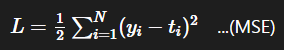

모델의 **mse 행렬**을 구하면 다음과 같음

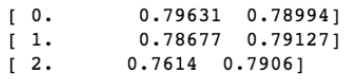